In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import time
import pandas as pd
%matplotlib inline

In [38]:
path = "./data"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}

data_image = {x:datasets.ImageFolder(root = os.path.join(path,x),
                                     transform = transform[x])
              for x in ["train", "val"]}

data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                num_workers=4,
                                                batch_size=24,
                                                pin_memory=True,
                                                shuffle = True)
                     for x in ["train", "val"]}

dataset_sizes = {x: len(data_image[x]) for x in ['train', 'val']}

/usr/local/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
/usr/local/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [39]:
dataset_sizes
print(u"训练集个数:", dataset_sizes["train"])
print(u"验证集个数:", dataset_sizes["val"])

训练集个数: 22500
验证集个数: 2500


In [40]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [41]:
class_names = data_image['train'].classes
classes_index = data_image["train"].class_to_idx
# print(classes)
print(class_names)

['cat', 'dog']


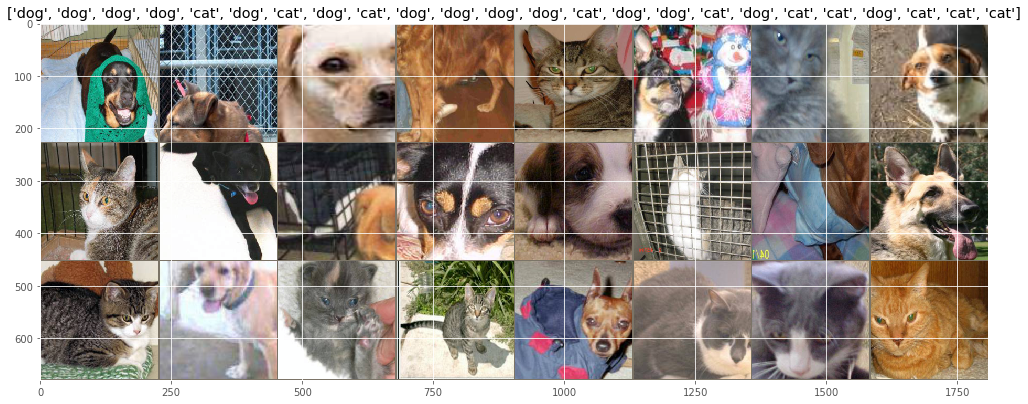

In [42]:
def imshow(inp, title=None):
    """显示Tensor类型的图片"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.figure(figsize=(17, 10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    

#一批训练集
inputs, classes = next(iter(data_loader_image['train']))

#对图片制作网格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[i] for i in classes])

In [43]:
import torchvision.models as models
model_names = sorted(name for name in models.__dict__ if name.islower() and not name.startswith("__"))
model_names

['alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'inception',
 'inception_v3',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [44]:
rst = {
        'train':[],
        'val':[]
      }

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = 0
    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每一轮都有一次训练和验证
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # 将模型设置为训练模式
            else:
                model.train(False)  # 将模型设置为验证模式

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for data in data_loader_image[phase]:
                # 得到输入数据
                inputs, labels = data

                # 将他们包装在Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # 梯度归零
                optimizer.zero_grad()

                # 前向传播
                outputs = model(inputs) #1
                _, preds = torch.max(outputs.data, 1) #2
                loss = criterion(outputs, labels)

                # 反向传播+参数优化，如果是处于训练时期
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 对每次迭代的loss和accuracy求和
                running_loss += loss.data[0] 
                running_corrects += torch.sum(preds == labels.data)
            # 统计每一轮的平均loss和accuracy   
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            rst[phase].append({'loss':epoch_loss, 'acc':epoch_acc})
            
            # 保存最好的模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = model.state_dict()
                
            print()
            
        now_time = time.time() - since   
        print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best epoch is : {}, val Acc: {:4f}'.format(best_epoch, best_acc))

    # 加载模型权重
    model.load_state_dict(best_model_wts) # 3
    return model


In [46]:
arch = 'resnet101'

In [47]:
model_conv = models.__dict__[arch](pretrained=True)

In [48]:
# 调整模型

for param in model_conv.parameters():
    param.requires_grad = False

# 新加的层默认设置 requires_grad=True 
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2) # 在resnet10之后增加一个全连接层

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# 仅仅优化最后一层的参数
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)


# 每隔7轮学习率变为原来的0.1倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, 
                                       step_size=7, 
                                       gamma=0.1)

In [114]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
  

In [104]:
loss_val = {}
for i in range(4):
    rst = {
        'train':[],
        'val':[]
      }
    print('%s : %s '%(i, 0.1/(10**i)))
    # 仅仅优化最后一层的参数
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.1/(100**i), momentum=0.9)
#     optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.1/(100**i))


    # 每隔7轮学习率变为原来的0.1倍
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, 
                                       step_size=7, 
                                       gamma=0.1)
    model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)
    
    loss_val[i] =rst

0 : 0.1 
Epoch 0/19
----------
train Loss: 0.1112 Acc: 0.9444

val Loss: 0.0076 Acc: 0.9940

Training time is:1m 5s
Epoch 1/19
----------
train Loss: 0.1004 Acc: 0.9455

val Loss: 0.0087 Acc: 0.9936

Training time is:1m 6s
Epoch 2/19
----------
train Loss: 0.1074 Acc: 0.9458

val Loss: 0.0071 Acc: 0.9948

Training time is:1m 7s
Epoch 3/19
----------
train Loss: 0.0913 Acc: 0.9490

val Loss: 0.0356 Acc: 0.9816

Training time is:1m 8s
Epoch 4/19
----------
train Loss: 0.0978 Acc: 0.9460

val Loss: 0.0105 Acc: 0.9924

Training time is:1m 8s
Epoch 5/19
----------
train Loss: 0.1019 Acc: 0.9471

val Loss: 0.0089 Acc: 0.9940

Training time is:1m 8s
Epoch 6/19
----------
train Loss: 0.0929 Acc: 0.9481

val Loss: 0.0127 Acc: 0.9928

Training time is:1m 9s
Epoch 7/19
----------
train Loss: 0.0588 Acc: 0.9606

val Loss: 0.0083 Acc: 0.9936

Training time is:1m 9s
Epoch 8/19
----------
train Loss: 0.0565 Acc: 0.9562

val Loss: 0.0087 Acc: 0.9916

Training time is:1m 8s
Epoch 9/19
----------
train 

train Loss: 0.0496 Acc: 0.9570

val Loss: 0.0068 Acc: 0.9928

Training time is:1m 13s
Epoch 15/19
----------
train Loss: 0.0523 Acc: 0.9546

val Loss: 0.0072 Acc: 0.9920

Training time is:1m 12s
Epoch 16/19
----------
train Loss: 0.0481 Acc: 0.9582

val Loss: 0.0075 Acc: 0.9928

Training time is:1m 12s
Epoch 17/19
----------
train Loss: 0.0480 Acc: 0.9584

val Loss: 0.0071 Acc: 0.9924

Training time is:1m 12s
Epoch 18/19
----------
train Loss: 0.0495 Acc: 0.9568

val Loss: 0.0073 Acc: 0.9932

Training time is:1m 12s
Epoch 19/19
----------
train Loss: 0.0485 Acc: 0.9585

val Loss: 0.0070 Acc: 0.9920

Training time is:1m 12s
Training complete in 1m 12s
Best val Acc: 0.993600


In [105]:
df = pd.DataFrame(loss_val).T

In [106]:
df_list = []
for i in range(4):
    tmp_df = pd.DataFrame(df['val'][i])
    tmp_df.columns = ['acc_%s' % i, 'loss_%s' % i]
    df_list.append(tmp_df) 

In [98]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.style.use('ggplot')

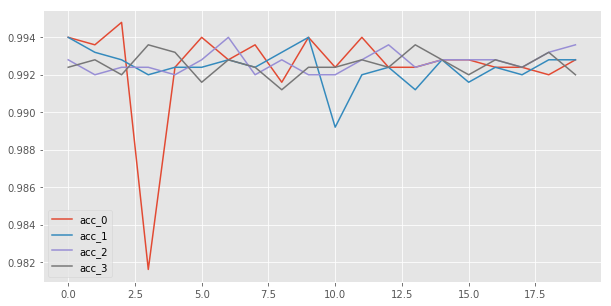

In [111]:
pd.concat(df_list,axis=1)[['acc_0','acc_1','acc_2','acc_3']].plot()

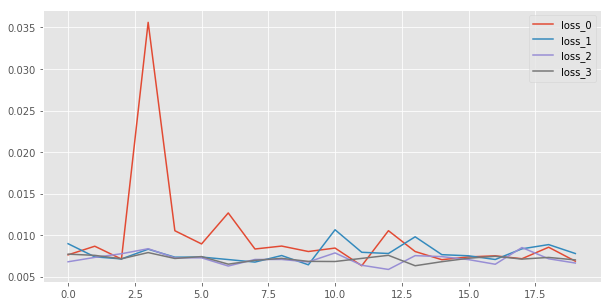

In [110]:
pd.concat(df_list,axis=1)[['loss_0','loss_1','loss_2','loss_3']].plot()

In [ ]:
rst['val']

In [112]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    # next(iter(data_loader_image['train']))
    for i, data in enumerate(data_loader_image['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            imshow(inputs.cpu().data[j],'predicted: {}'.format(class_names[preds[j]]))
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

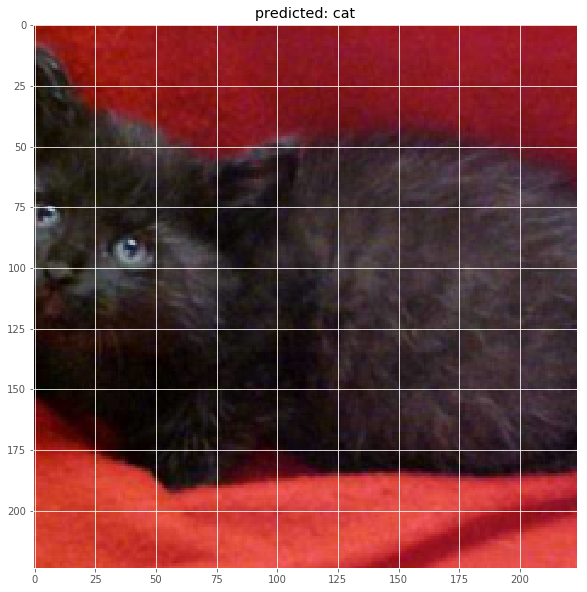

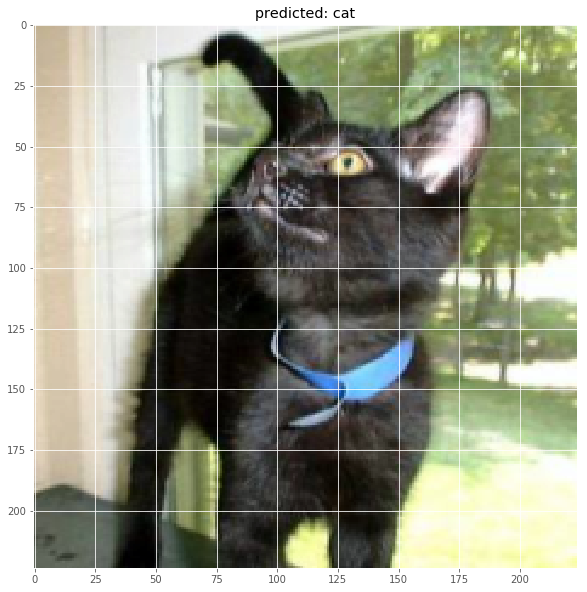

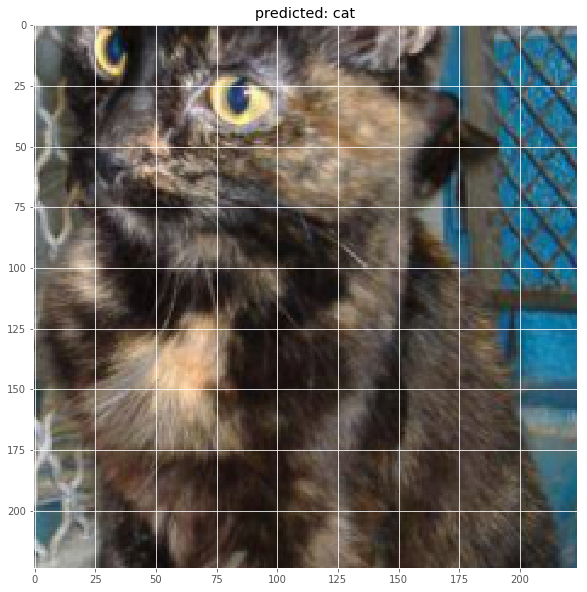

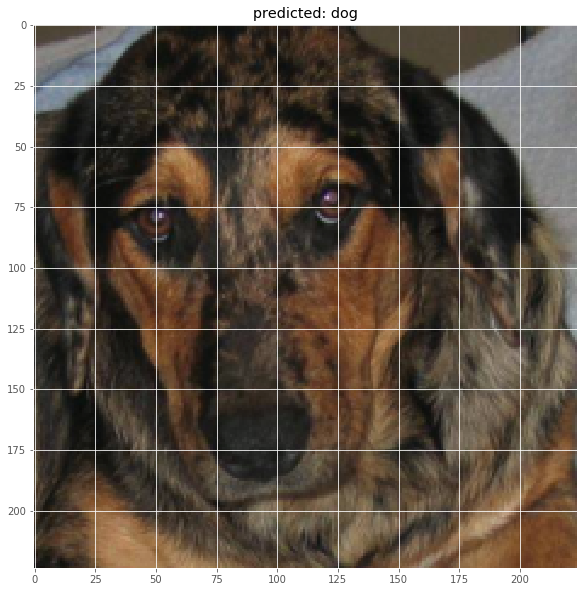

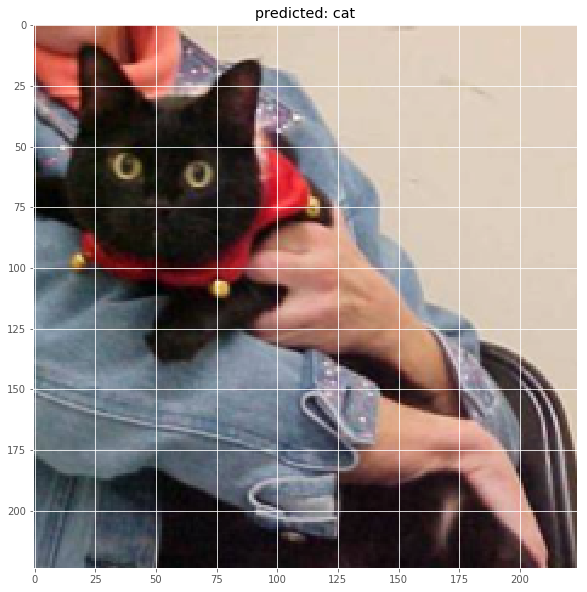

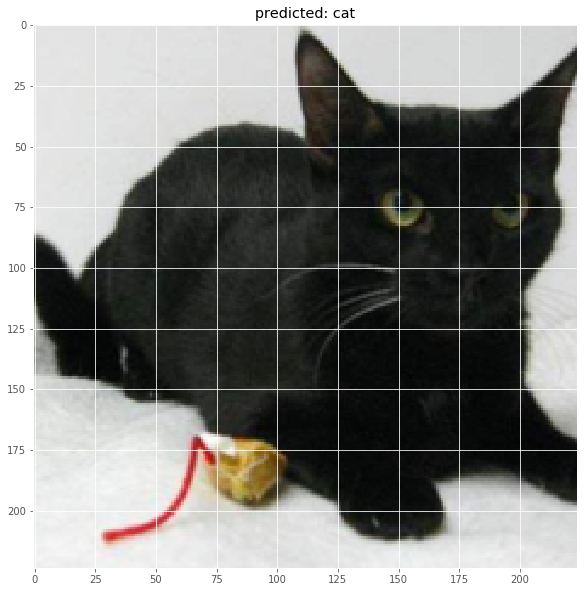

In [113]:
visualize_model(model_conv)


In [ ]:
torch.save(model_conv.state_dict(), "model_%s_finetune.pkl" % arch)

In [ ]:
model.load_state_dict(torch.load('model_%s_finetune.pkl' % arch))

In [ ]:
dir(torch)

In [18]:
class ImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, path
    

In [19]:
data_test_img = ImageFolder(root="./test/",
                                     transform = transform['val'])
data_loader_test_img = torch.utils.data.DataLoader(dataset=data_test_img,
                                                   batch_size = 1)

In [21]:
import collections
clip = 0.005
cnt = 1
csv_map = {}

for image, label, path in data_loader_test_img:
    images = Variable(image.cuda())
    y_pred = model_conv(images)
    smax = torch.nn.Softmax()
    smax_out = smax(y_pred)[0]
    cat_prob = smax_out.data[0]
    dog_prob = smax_out.data[1]
    prob = dog_prob

    if cat_prob > dog_prob:
        prob = 1 - cat_prob
    prob = np.around(prob, decimals=4)
    prob = np.clip(prob, clip, 1-clip)
    filepath = path[0].split('/')[-1].split('.')[-2]
    
    csv_map[filepath] = prob
    


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [22]:
csv_list = []
for k,v in csv_map.items():
    csv_list.append((k,v))

len(csv_list)

12500

In [23]:
df = pd.DataFrame(csv_list)
df.columns = ['id','label']
df.id = df.id.astype(int)
df = df.sort_values('id')

In [24]:
df.to_csv('result_%s.csv' % arch,index=False)

In [25]:
'result_%s.csv' % arch

'result_resnet101.csv'

In [ ]:
df.groupby('id').count()